In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# pip install fuzzymatcher
# https://github.com/RobinL/fuzzymatcher/issues/42

from fuzzymatcher import link_table, fuzzy_left_join
import fuzzymatcher

# fuzzymatcher.link_table(df_left, df_right, left_on, right_on)

## Spotify Data, Pitchfork Reviews

First, we are going to upload to the acoustic_features.csv, albums.csv, and reviews.csv file.

In [4]:
acoustics = pd.read_csv("acoustic_features.csv")
billboard = pd.read_csv("albums.csv")
pitchfork = pd.read_csv("reviews.csv")
billboard_pitchfork = pd.read_pickle("./grouped_billboard.pkl")

In [5]:
pitchfork.head()

,index,id,artist,album,genre,score,date,author,role,review,bnm,link
0,0,0,David Byrne,“…The Best Live Show of All Time” — NME EP,Rock,5.5,January 11 2019,Andy Beta,Contributor,"Viva Brother, Terris, Mansun, the Twang, Joe L...",0,https://pitchfork.com/reviews/albums/david-byr...
1,1,1,DJ Healer,Lost Lovesongs / Lostsongs Vol. 2,Electronic,6.2,January 11 2019,Chal Ravens,Contributor,"The Prince of Denmark—that is, the proper prin...",0,https://pitchfork.com/reviews/albums/dj-healer...
2,2,2,Jorge Velez,Roman Birds,Electronic,7.9,January 10 2019,Philip Sherburne,Contributing Editor,"Jorge Velez has long been prolific, but that’s...",0,https://pitchfork.com/reviews/albums/jorge-vel...
3,3,3,Chandra,Transportation EPs,Rock,7.8,January 10 2019,Andy Beta,Contributor,When the Avalanches returned in 2016 after an ...,0,https://pitchfork.com/reviews/albums/chandra-t...
4,4,4,The Chainsmokers,Sick Boy,Electronic,3.1,January 9 2019,Larry Fitzmaurice,Contributor,We’re going to be stuck with the Chainsmokers ...,0,https://pitchfork.com/reviews/albums/the-chain...


## Size of each data set:

In [6]:
print("The size of the acoustics dataset is:","{:,}".format(acoustics.shape[0]), "rows.")
print("The size of the billboard dataset is:","{:,}".format(billboard.shape[0]), "rows.")
print("The size of the pitchfork dataset is:","{:,}".format(pitchfork.shape[0]), "rows.")

The size of the acoustics dataset is: 339,855 rows.
The size of the billboard dataset is: 573,947 rows.
The size of the pitchfork dataset is: 20,873 rows.


## Data Cleaning: String Lowercasing Artist and Album in Pitchfork and Billboard

In [7]:
pitchfork.iloc[199,:]

index                                                   199
id                                                      199
artist                                   Future, Juice WRLD
album                                         WRLD on Drugs
genre                                                   Rap
score                                                   6.3
date                                        October 25 2018
author                                       Torii MacAdams
role                                                    NaN
review    Future plays a narcissist who wants nothing mo...
bnm                                                       0
link      https://pitchfork.com/reviews/albums/future-ju...
Name: 199, dtype: object

In [8]:
"""
"ó", "é", "+", ",", "ö", ""
"rancid/nofx" vs. "rancidand nofx"
.replace("_"," ")
remove "*"
remove "-"
"ç","c"
""
" da", ""
"-", " "
"melvins", "the melvins"
"""

p_artist = pitchfork["artist"].str.lower()
p_artist = p_artist.str.replace("&"," and")
p_artist = p_artist.str.replace("$", "s")
p_artist = p_artist.str.replace(".","")
p_artist = p_artist.str.replace("ó","o")
p_artist = p_artist.str.replace("ö","o")
p_artist = p_artist.str.replace(","," and")
p_artist = p_artist.str.replace("é","e")
p_artist = p_artist.str.replace("é","e")
p_artist = p_artist.str.replace("+","and")
p_artist = p_artist.str.replace("ç","c")
p_artist = p_artist.str.replace("*","")
p_artist = p_artist.str.replace("-"," ")
p_artist = p_artist.str.replace(" da", "")
p_artist = p_artist.str.replace("/", " and ")
p_artist = p_artist.str.replace("melvins", "the melvins")
p_artist = p_artist.str.replace("futureand", "future and")
p_album = pitchfork["album"].str.lower()
pitchfork["artist"] = p_artist
pitchfork["album"] = p_album

b_artist = billboard["artist"].str.lower()
b_artist = b_artist.str.replace("&"," and")
b_artist = b_artist.str.replace("$", "s")
b_artist = b_artist.str.replace(".","")
b_artist = b_artist.str.replace("ó","o")
b_artist = b_artist.str.replace("ö","o")
b_artist = b_artist.str.replace(","," and")
b_artist = b_artist.str.replace("é","e")
b_artist = b_artist.str.replace("é","e")
b_artist = b_artist.str.replace("+","and")
b_artist = b_artist.str.replace("ç","c")
b_artist = b_artist.str.replace("*","")
b_artist = b_artist.str.replace("-"," ")
b_artist = b_artist.str.replace(" da", "")
b_artist = b_artist.str.replace("/", " and ")
b_artist = b_artist.str.replace("melvins", "the melvins")
b_artist = b_artist.str.replace("futureand", "future and")


b_album = billboard["album"].str.lower()
billboard["artist"] = b_artist
billboard["album"] = b_album
billboard = billboard.iloc[1:]

## Fuzzy Matching

In [9]:
billboard.query("album=='Flower Boy'");

In [10]:
billboard[billboard['artist'] == "Japandroids"]

,index,id,date,artist,album,rank,length,track_length


In [11]:
bad_artists = ['Japandroids', 'Sammy Kershaw', 'Keef Hartley Band', 'Vanilla Fudge']

grouped_billboard = billboard.loc[billboard.groupby(["album"])["rank"].idxmin()]
grouped_billboard = grouped_billboard.sort_values(by="date",ascending=False)
grouped_billboard = grouped_billboard[grouped_billboard['artist'] != "japandroids"]
grouped_billboard = grouped_billboard[grouped_billboard['artist'] != "sammy kershaw"]
grouped_billboard = grouped_billboard[grouped_billboard['artist'] != "keef hartley band"]
print(grouped_billboard.query("artist == 'Vanilla Fudge'"))
grouped_billboard = grouped_billboard[grouped_billboard['artist'] != "vanilla fudge"]



Empty DataFrame
Columns: [index, id, date, artist, album, rank, length, track_length]
Index: []


In [13]:
len(grouped_billboard.head())

5

In [ ]:
#Fuzzymatcher

left_on = ['artist', 'album'] # BB
right_on = ['artist', 'album'] # PF

#df = fuzzymatcher.link_table(grouped_billboard, pitchfork.iloc[:-1], left_on, right_on, left_id_col = "index", right_id_col = "index")

## The Final Version Gets Saved To A Pickle

In [ ]:
df.to_pickle('./fuzzymatched.pkl')
#original_df.to_pickle("./dummy.pkl")

In [24]:
df = pd.read_pickle('fuzzymatched.pkl')

## Fuzzy match complete: joining good_rows to grouped_billboard

In [ ]:
good_rows = df[df["match_score"] > 0.6]
good_rows = good_rows[good_rows["match_rank"] == 1]
good_rows = good_rows.rename(index=str, columns={"__id_right": "pitchfork_id", "__id_left": "billboard_id"})
good_rows.head()

Processing the fuzzybillboard dataset.

In [ ]:
fuzzybillboard = grouped_billboard.merge(good_rows, left_on='index', right_on='billboard_id', how = "left") #.sort_values(by='date', ascending = False)
fuzzybillboard

In [ ]:
billfuzzypitch = fuzzybillboard.merge(pitchfork, left_on = "pitchfork_id", right_on="index", how="left")
#pitch = billfuzzypitch["review"].isnull()
#pitch
billfuzzypitch = billfuzzypitch.sort_values(by=['date_x', 'rank'], ascending = [False, True])

In [ ]:
billfuzzypitch["hasreview"] = billfuzzypitch['review'].notnull()
billfuzzypitch.query("hasreview == True")

## Now dropping unnecessary columns from the billfuzzypitch dataset 

In [ ]:
## TO DO LIST:
# Drop the id_x colum
#rename the index_x album billboard_id and delete the billboard_id colum


In [ ]:
billfuzzypitch.head()

In [ ]:
billfuzzypitch = billfuzzypitch.drop(columns = ['id_x','billboard_id','match_score','match_rank','artist_left','artist_right','artist_y','album_left', 'album_right','album_y', 'index_y','id_y'])
billfuzzypitch = billfuzzypitch.rename(index = str, columns = {"index_x":"billboard index","date_x":"billboard date","artist_x":"artist","album_x":"album","pitchfork_id": "pitchfork index", "track_length": "track length", "date_y": "date of review", "rank": "billboard rank", "score": "pitchfork score"})

In [ ]:
billfuzzypitch.head()

In [ ]:
df.to_pickle('./grouped_billboardandpitchfork1.pkl')\

## Finished

In [ ]:
billfuzzypitch.head()

In [ ]:
billfuzzypitch.to_pickle('./BILLFUZZYPITCHFINISHED.pkl')

In [14]:
billfuzzypitch = pd.read_pickle('./BILLFUZZYPITCHFINISHED.pkl')

In [224]:
billfuzzypitch.query("artist == 'arcade fire'")

,billboard index,billboard date,artist,album,billboard rank,length,track length,pitchfork index,genre,pitchfork score,date of review,author,role,review,bnm,link,hasreview,no punc,polarity
985,14801,2017-08-19,arcade fire,everything now,1.0,13.0,233972.923077,1745.0,Rock,5.6,July 28 2017,Jeremy D. Larson,Senior Editor,arcade fire became a new band for their 2013 a...,0.0,https://pitchfork.com/reviews/albums/arcade-fi...,True,arcade fire became a new band for their 2013 a...,-32.4
4344,54001,2013-11-16,arcade fire,reflektor,1.0,13.0,384785.461538,6203.0,Rock,9.2,October 28 2013,Lindsay Zoladz,Contributor,it s likely that the first time you heard the ...,1.0,https://pitchfork.com/reviews/albums/18667-arc...,True,it s likely that the first time you heard the ...,31.0
6746,78323,2011-07-23,arcade fire,funeral,123.0,10.0,288001.000000,17032.0,Rock,9.7,September 12 2004,David Moore,Contributor,how did we get here ours is a generation over...,1.0,https://pitchfork.com/reviews/albums/452-funeral/,True,how did we get here ours is a generation over...,-22.3
7692,87801,2010-08-21,arcade fire,the suburbs,1.0,16.0,240316.375000,10024.0,Rock,8.6,August 2 2010,Ian Cohen,Contributor,arcade fire never aim for anything less than g...,1.0,https://pitchfork.com/reviews/albums/14516-the...,True,arcade fire never aim for anything less than g...,-4.7
10917,123402,2007-03-24,arcade fire,neon bible,2.0,11.0,256671.181818,14115.0,Rock,8.4,March 5 2007,Stephen M. Deusner,Contributor,sharing its title with a john kennedy toole no...,1.0,https://pitchfork.com/reviews/albums/9946-neon...,True,sharing its title with a john kennedy toole no...,1.5


## Exploratory Data Analysis

## What genre of albums are most frequently reviewed?

In [233]:
genres = billfuzzypitch[billfuzzypitch['hasreview'] == True]
genres

a = billfuzzypitch.groupby(['genre'])['genre'].count().sort_values(ascending=False)
a = a[0:10]

b = pitchfork.groupby(['genre'])['genre'].count().sort_values(ascending=False)
b = b[0:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

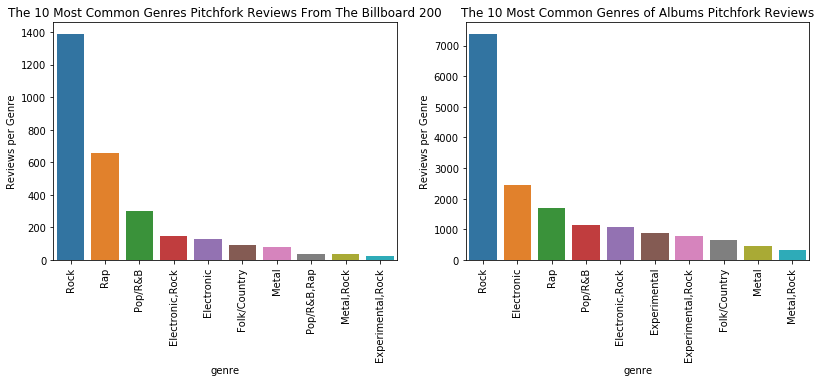

In [237]:
#Let's look at the genre
plt.figure(figsize = [12,12])
plt.subplot(1,2,1)
plt.title("The 10 Most Common Genres Pitchfork Reviews From The Billboard 200") #title for subplots
#plt.xlabel("Genre") #title for x axis
plt.ylabel("Reviews per Genre") #title for y axis
sns.barplot(x = a.index, y = a.values)
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.subplots_adjust(right = 1.0, top = 0.4)
plt.title("The 10 Most Common Genres of Albums Pitchfork Reviews") #title for subplots
#plt.xlabel("Genre") #title for x axis
plt.ylabel("Reviews per Genre") #title for y axis
sns.barplot(x = b.index, y = b.values)
plt.xticks(rotation='vertical')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

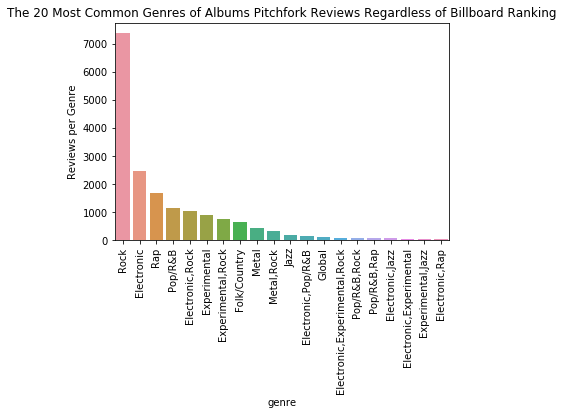

In [17]:
plt.figure()
plt.title("The 20 Most Common Genres of Albums Pitchfork Reviews Regardless of Billboard Ranking") #title for subplots
#plt.xlabel("Genre") #title for x axis
plt.ylabel("Reviews per Genre") #title for y axis
sns.barplot(x = b.index, y = b.values)
plt.xticks(rotation='vertical')

Pitchfork likes Rock music. They also don't classify any of the albums they review as Indie, which is funny since Pitchfork clearly loves Indie music.

## Which genres does Pitchfork like?

In [29]:
billfuzzypitch

,billboard index,billboard date,artist,album,billboard rank,length,track length,pitchfork index,genre,pitchfork score,date of review,author,role,review,bnm,link,hasreview
8,1,2019-01-19,a boogie wit hoodie,hoodie szn,1.0,20.0,185233.800000,6.0,Rap,6.8,January 8 2019,Alphonse Pierre,Staff Writer,"In New York, time moves at its own pace: Faceb...",0.0,https://pitchfork.com/reviews/albums/a-boogie-...,True
7,3,2019-01-19,soundtrack,spider-man: into the spider-verse,3.0,13.0,190866.384615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,15,2019-01-19,youngboy never broke again,realer,15.0,12.0,167016.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,19,2019-01-19,billie eilish,dont smile at me,19.0,9.0,193268.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,41,2019-01-19,benny blanco,friends keep secrets (ep),41.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6,112,2019-01-19,dolly parton,ultimate dolly parton,112.0,20.0,186537.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,144,2019-01-19,r kelly,the essential r. kelly,144.0,35.0,280513.971429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
0,162,2019-01-19,blueface,famous cryp,162.0,10.0,126781.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,192,2019-01-19,ynw melly,i am you,192.0,15.0,223340.133333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
11,201,2019-01-12,21 savage,i am > i was,1.0,15.0,211050.733333,17.0,Rap,7.8,January 2 2019,Paul A. Thompson,Contributor,"The jarringly sober track “a lot,” which opens...",0.0,https://pitchfork.com/reviews/albums/21-savage...,True


In [30]:
genres = billfuzzypitch[billfuzzypitch['hasreview'] == True]
genres

c = genres.groupby(['genre'])['pitchfork score'].mean().sort_values(ascending=False)

d = pitchfork.groupby(['genre'])['score'].mean().sort_values(ascending=False)

In [31]:
c

genre
Electronic,Experimental,Rock            8.600000
Jazz                                    8.550000
Electronic,Experimental                 8.400000
Jazz,Pop/R&B                            8.200000
Experimental,Rap                        8.033333
Experimental                            7.795833
Rock,Experimental                       7.712500
Electronic,Global                       7.700000
Folk/Country                            7.562366
Pop/R&B,Rock                            7.561538
Global,Rock                             7.500000
Metal                                   7.412500
Experimental,Rock                       7.404000
Folk/Country,Jazz,Pop/R&B               7.300000
Pop/R&B,Folk/Country                    7.200000
Pop/R&B                                 7.118667
Electronic,Folk/Country                 7.100000
Rock                                    7.065396
Global                                  7.060000
Electronic,Pop/R&B                      7.050000
Jazz,Metal    

In [32]:
d

genre
Pop/R&B,Global                          9.500000
Jazz,Pop/R&B,Global                     8.666667
Electronic,Rock,Experimental,Global     8.600000
Electronic,Global,Pop/R&B               8.500000
Rap,Electronic,Jazz                     8.500000
Global,Pop/R&B,Jazz                     8.300000
Experimental,Global,Rock                8.300000
Electronic,Experimental,Folk/Country    8.200000
Jazz,Global,Rap                         8.100000
Global,Jazz,Pop/R&B                     8.020000
Folk/Country,Global,Pop/R&B             8.016667
Electronic,Metal,Experimental           8.000000
Jazz,Global                             7.900000
Jazz,Experimental,Folk/Country          7.900000
Electronic,Rock,Jazz                    7.800000
Electronic,Folk/Country,Rock            7.800000
Jazz,Electronic                         7.800000
Global,Rock                             7.762500
Electronic,Global,Rock                  7.750000
Experimental,Global                     7.714286
Electronic,Roc

In [33]:
good_rows.shape

(3147, 8)

In [34]:
blahblah = genres[genres['pitchfork score'] >= 6]

In [35]:
print(len(blahblah)/(len(good_rows)))

0.7785192246584048


Only 10% of all of the albums Pitchfork has ever reviewed actually got a score of 8.4 or above. On a grading scale, an 8.4 is an A. With that same logic in mind, what's an F? 57.8% of all albums reviewed received a 7.4 or less.

In [36]:
blahblahblah = pitchfork[pitchfork['score'] >= 8.4]

In [37]:
print(len(blahblahblah)/(len(pitchfork)))

0.09754227949983232


In [38]:
blahblahblah = pitchfork[pitchfork['score'] <= 7.4]

In [39]:
print(len(blahblahblah)/(len(pitchfork)))

0.5784506300004791


(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 8 Text xticklabel objects>)

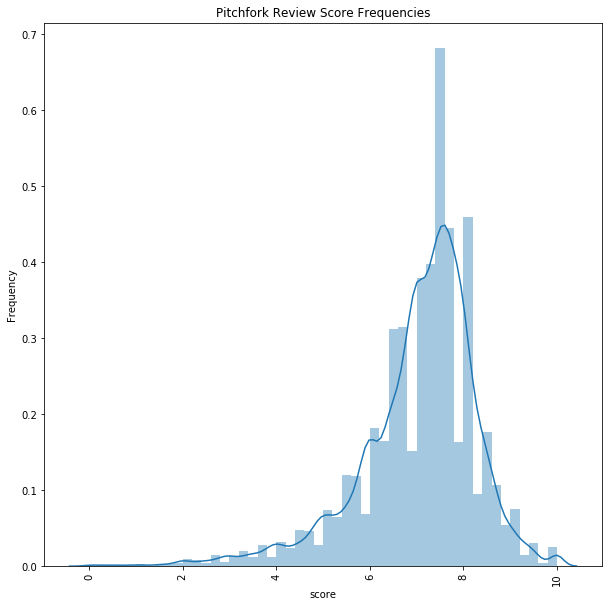

In [40]:
plt.figure(figsize = [10,10])
plt.title("Pitchfork Review Score Frequencies") #title for subplots
#plt.xlabel("Genre") #title for x axis
plt.ylabel("Frequency") #title for y axis
sns.distplot(pitchfork['score'])
plt.xticks(rotation='vertical')

In [41]:
print(pitchfork['score'].mean())
print(pitchfork['score'].median())

7.039357064149771
7.3


(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 8 Text xticklabel objects>)

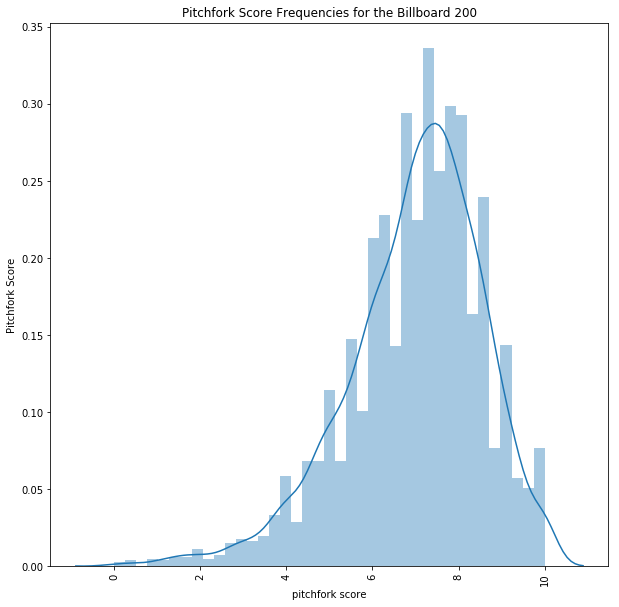

In [238]:
plt.figure(figsize = [10,10])
plt.title("Pitchfork Score Frequencies for the Billboard 200") #title for subplots
#plt.xlabel("Genre") #title for x axis
plt.ylabel("Frequency") #title for y axis
plt.ylabel("Pitchfork Score")
sns.distplot(genres['pitchfork score'])
plt.xticks(rotation='vertical')

In [226]:
genres['pitchfork score'].median()

7.2

## Correlation Matrix for Pitchfork Scores and Billboard Rankings

**Correlation Matrix: ALL OF OUR PREDICTORS ARE BELONG TO US**

In [61]:
df1 = billfuzzypitch.filter(['billboard rank', 'length', 'track length', 'pitchfork score', 'bnm'], axis = 1)
df1.head(3)

,billboard rank,length,track length,pitchfork score,bnm
8,1.0,20.0,185233.800000,6.8,0.0
7,3.0,13.0,190866.384615,NaN,NaN
2,15.0,12.0,167016.083333,NaN,NaN


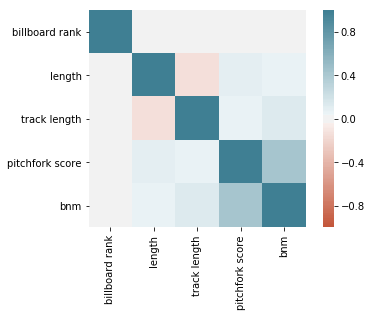

In [62]:
sns.heatmap(df1.corr(),
                                vmin=-1, vmax=1, center=0,
                                cmap=sns.diverging_palette(20, 220, n=200),
                                square=True)
#mov_data = ['billboard index', 'billboard date', 'artist', 'album', 'billboard rank', 'length', 'track length', 'pitchfork index', 'genre', 'pitchfork score', 'date of review', 'author', 'author', 'role', 'review', 'bnm', 'link', 'hasreview']
#ax.set_xticklabels(mov_data)
#ax.set_yticklabels(mov_data)
plt.show()

In [64]:
corr_df = df1.corr()
corr_df

,billboard rank,length,track length,pitchfork score,bnm
billboard rank,1.000000,-0.015793,0.005380,0.029139,-0.013303
length,-0.015793,1.000000,-0.137687,0.099990,0.065669
track length,0.005380,-0.137687,1.000000,0.069476,0.129059
pitchfork score,0.029139,0.099990,0.069476,1.000000,0.434069
bnm,-0.013303,0.065669,0.129059,0.434069,1.000000


In [59]:
df1 = billfuzzypitch.filter(['billboard index', 'billboard rank', 'length', 'track length', 'pitchfork index', 'pitchfork score', 'bnm'], axis = 1)
df1.head(3)

,billboard index,billboard rank,length,track length,pitchfork index,pitchfork score,bnm
8,1,1.0,20.0,185233.800000,6.0,6.8,0.0
7,3,3.0,13.0,190866.384615,NaN,NaN,NaN
2,15,15.0,12.0,167016.083333,NaN,NaN,NaN


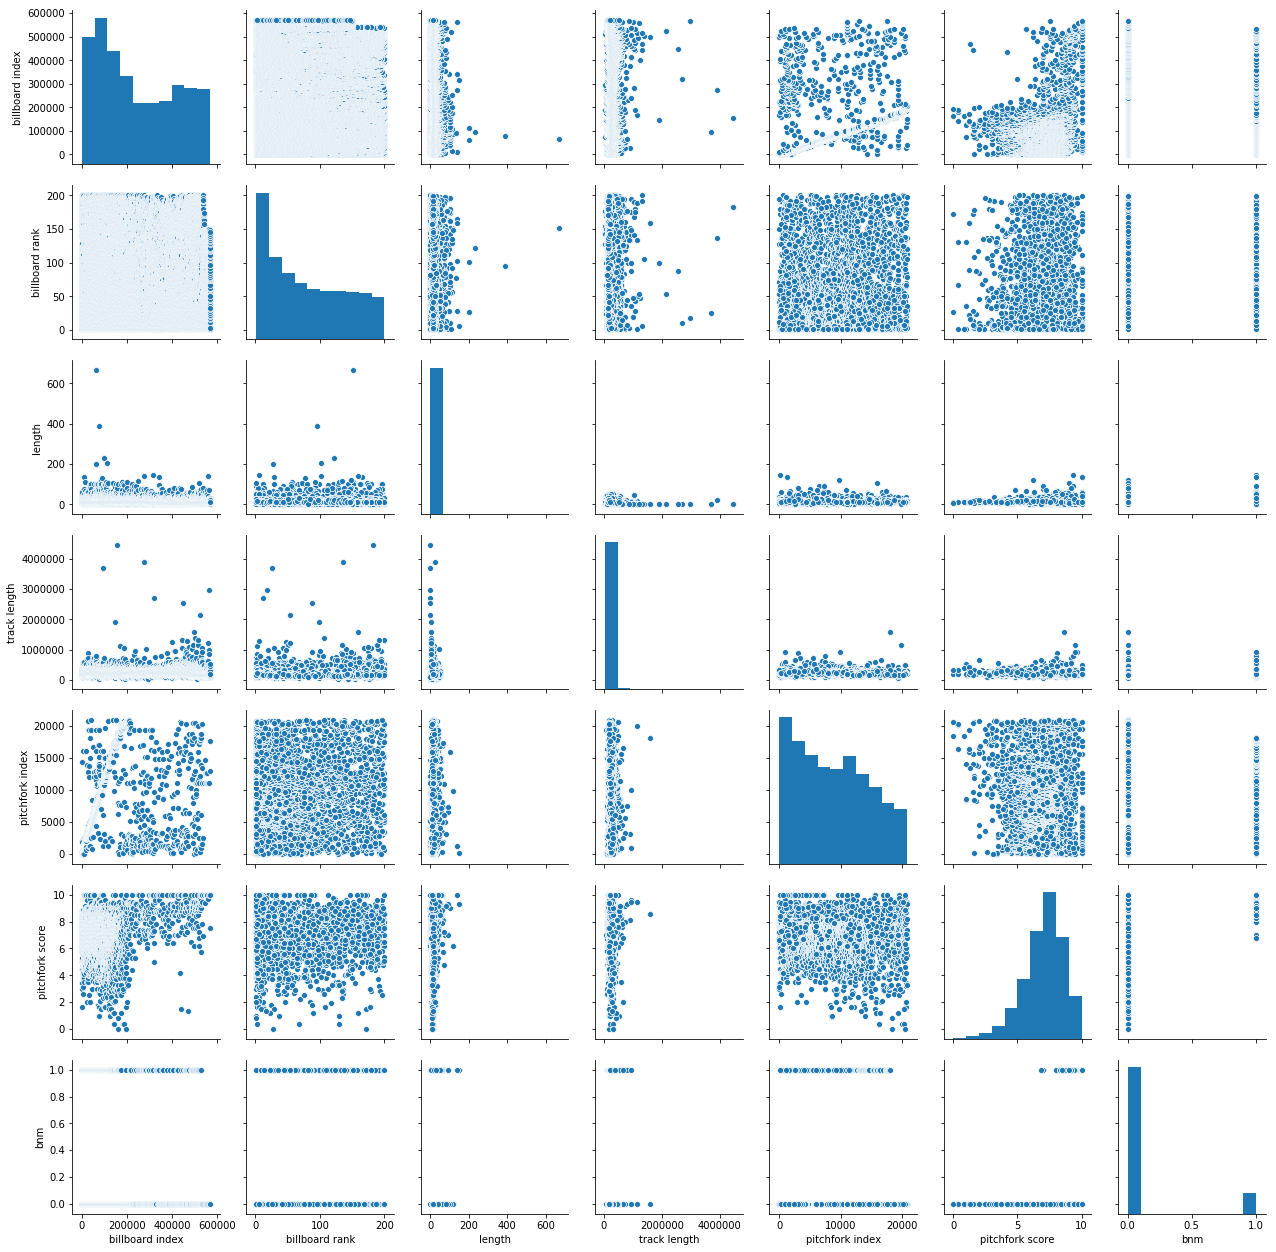

In [60]:
sns.pairplot(df1)

There's a slight negative correlation between Pitchfork labeling an albumn "Best New Music" and a slight positive correlation between a high Pitchfork score and a low Billboard ranking. This is interesting, and could simply be due to the random sampling nature of the data. It could also be that Pitchfork prefers albums that aren't generally popular to the public. The "Best New Music"'s negative correlation seems to imply that getting stamped "Best New Music" correlates with a slight uptick in billboard ranking.

## Measuring the Polarity of the Billboard 200

Getting the polarity scores of different words.

In [66]:
sent = pd.read_csv("vader_lexicon.txt",
                   header = None, 
                   names = ["token", "polarity", "standard deviation", "raw-human-sentiment-rating"],
                   sep = "\t",
                   usecols = [0,1],
                   index_col = "token")
sent.head(5)

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [75]:
billfuzzypitch['review'] = billfuzzypitch['review'].str.lower()
punct_re = r'[^\w\s]'
billfuzzypitch['no punc'] = billfuzzypitch['review'].str.replace(punct_re, " ")
tidy_format = billfuzzypitch['no punc'].str.split(expand= True).stack().reset_index(level=1).rename(columns={"level_1": "num", 0: "word"})

,num,word
8,0,in
8,1,new
8,2,york
8,3,time
8,4,moves


In [220]:
billfuzzypitch['polarity'] = (
    tidy_format
    .merge(sent, how='left', left_on='word', right_index=True)
    .reset_index()
    .loc[:, ['index','polarity']]
    .groupby('index')
    .sum()
    .fillna(0)
)

#billfuzzypitch.query("hasreview == True")

## Now to see if there's a correlation between review polarity and either Billboard Ranking or 

In [82]:
df2 = billfuzzypitch.filter(['billboard rank', 'length', 'track length', 'pitchfork score', 'bnm', 'polarity'], axis = 1)

In [85]:
df2.corr()

,billboard rank,length,track length,pitchfork score,bnm,polarity
billboard rank,1.000000,-0.015793,0.005380,0.029139,-0.013303,-0.008543
length,-0.015793,1.000000,-0.137687,0.099990,0.065669,0.058880
track length,0.005380,-0.137687,1.000000,0.069476,0.129059,0.059882
pitchfork score,0.029139,0.099990,0.069476,1.000000,0.434069,0.190009
bnm,-0.013303,0.065669,0.129059,0.434069,1.000000,0.148416
polarity,-0.008543,0.058880,0.059882,0.190009,0.148416,1.000000


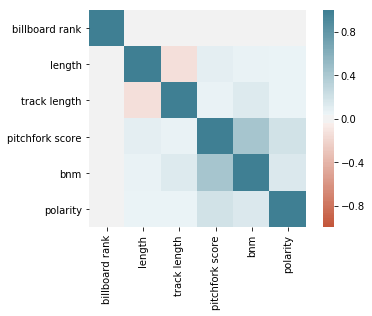

In [83]:
sns.heatmap(df2.corr(),
                                vmin=-1, vmax=1, center=0,
                                cmap=sns.diverging_palette(20, 220, n=200),
                                square=True)
#mov_data = ['billboard index', 'billboard date', 'artist', 'album', 'billboard rank', 'length', 'track length', 'pitchfork index', 'genre', 'pitchfork score', 'date of review', 'author', 'author', 'role', 'review', 'bnm', 'link', 'hasreview']
#ax.set_xticklabels(mov_data)
#ax.set_yticklabels(mov_data)
plt.show()

''

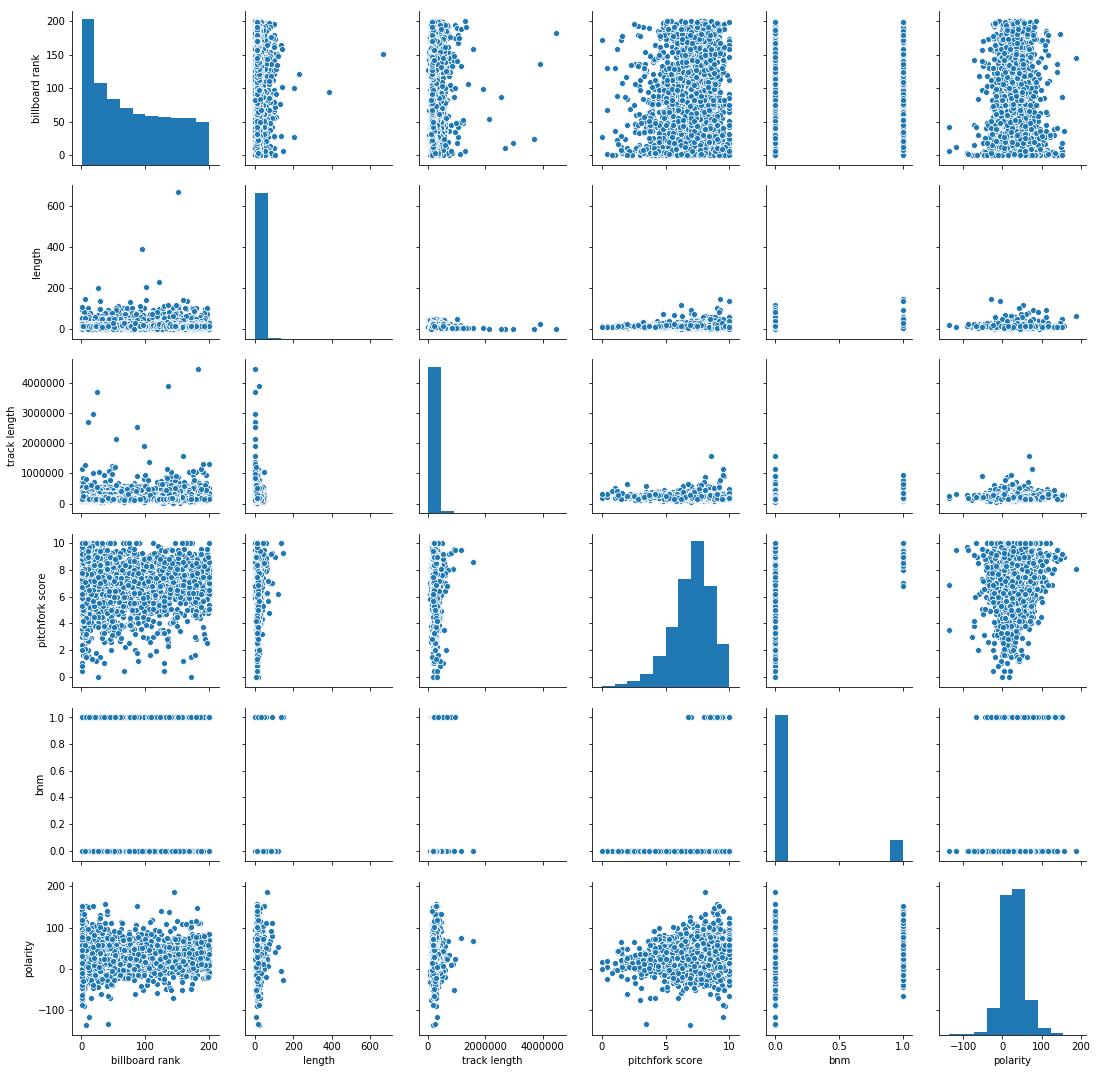

In [87]:
sns.pairplot(df2)
;

## Multiple Linear Regression: Regressing Billboard Rank on Numerical Features

Does Pitchfork Polarity and album ranking bear any weight on Billboard 200?

In [98]:
from sklearn.datasets import load_diabetes
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm



In [124]:
model_data[model_data["bnm"] != None]

,billboard index,billboard date,artist,album,billboard rank,length,track length,pitchfork index,genre,pitchfork score,date of review,author,role,review,bnm,link,hasreview,no punc,polarity
8,1,2019-01-19,a boogie wit hoodie,hoodie szn,1.0,20.0,185233.800000,6.0,Rap,6.8,January 8 2019,Alphonse Pierre,Staff Writer,in new york time moves at its own pace faceb...,0.0,https://pitchfork.com/reviews/albums/a-boogie-...,True,in new york time moves at its own pace faceb...,6.4
11,201,2019-01-12,21 savage,i am > i was,1.0,15.0,211050.733333,17.0,Rap,7.8,January 2 2019,Paul A. Thompson,Contributor,the jarringly sober track a lot which opens...,0.0,https://pitchfork.com/reviews/albums/21-savage...,True,the jarringly sober track a lot which opens...,15.4
12,211,2019-01-12,bad bunny,x 100pre,11.0,15.0,215771.933333,15.0,Rap,8.2,January 3 2019,Matthew Ismael Ruiz,Contributor,in the first three years of his nascent career...,0.0,https://pitchfork.com/reviews/albums/bad-bunny...,True,in the first three years of his nascent career...,-16.4
42,611,2018-12-29,bruce springsteen,springsteen on broadway,11.0,35.0,255173.714286,37.0,Rock,8.0,December 14 2018,Caryn Rose,Contributor,before the boss hit the boards at the walter k...,0.0,https://pitchfork.com/reviews/albums/bruce-spr...,True,before the boss hit the boards at the walter k...,24.2
44,616,2018-12-29,vince guaraldi trio,a charlie brown christmas (soundtrack),16.0,14.0,NaN,14351.0,Jazz,8.3,December 13 2006,Dominique Leone,Contributor,taken like a spoonful of nyquil just before yo...,0.0,https://pitchfork.com/reviews/albums/9688-a-ch...,True,taken like a spoonful of nyquil just before yo...,42.9
43,661,2018-12-29,zayn,icarus falls,61.0,27.0,194914.296296,30.0,Pop/R&B,6.4,December 18 2018,Maura Johnston,Contributor,zayn fka zayn malik fka one fifth of the brit...,0.0,https://pitchfork.com/reviews/albums/zayn-icar...,True,zayn fka zayn malik fka one fifth of the brit...,46.0
47,801,2018-12-22,xxxtentacion,skins,1.0,10.0,118759.000000,39.0,Rap,3.0,December 14 2018,Sheldon Pearce,Contributing Writer,at the center of the jahseh onfroy story is hi...,0.0,https://pitchfork.com/reviews/albums/xxxtentac...,True,at the center of the jahseh onfroy story is hi...,-76.6
55,805,2018-12-22,gucci mane,evil genius,5.0,18.0,169215.500000,45.0,Rap,6.5,December 11 2018,Evan Rytlewski,Contributor,evil genius might be the first album in gucci ...,0.0,https://pitchfork.com/reviews/albums/gucci-man...,True,evil genius might be the first album in gucci ...,15.3
54,928,2018-12-22,coldplay,live in buenos aires,128.0,24.0,286136.375000,40.0,Rock,6.1,December 13 2018,Sam Sodomsky,Associate Staff Writer,the difference between coldplay s hits and mis...,0.0,https://pitchfork.com/reviews/albums/coldplay-...,True,the difference between coldplay s hits and mis...,31.1
60,1001,2018-12-15,meek mill,championships,1.0,19.0,219173.894737,66.0,Rap,7.7,December 4 2018,Evan Rytlewski,Contributor,meek mill is now saddled with something bigger...,0.0,https://pitchfork.com/reviews/albums/meek-mill...,True,meek mill is now saddled with something bigger...,8.1


In [222]:
model_data = billfuzzypitch.query("hasreview == True")   
model_data = model_data.dropna()
model_data['intercept'] = 1

billboard_rank = model_data['billboard rank']

billboard_features = model_data.filter(['intercept','track length','length', 'pitchfork score', 'bnm', 'polarity'], axis = 1)

In [223]:
model_rankonfeatures = sm.OLS(billboard_rank, billboard_features).fit()
model_rankonfeatures.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         billboard rank   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.192
Date:                Fri, 14 Jun 2019   Prob (F-statistic):           0.000852
Time:                        18:13:24   Log-Likelihood:                -13569.
No. Observations:                2470   AIC:                         2.715e+04
Df Residuals:                    2464   BIC:                         2.718e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          54.2895      7.781      6.978      0.000      39.032      69.547
track length     1.989e-06    1.7e-05      0.117      0.907   -3.13e-05    3.52e-05
length             -0.8173      0.214     -3.811      0.000      -1.238      -0.397
pitchfork score     2.2848      0.866      2.637      0.008       0.586       3.984
bnm                -3.7215      3.865     -0.963      0.336     -11.300       3.857
polarity           -0.0137      0.041     -0.334      0.739      -0.094       0.067
==============================================================================
Omnibus:                      281.444   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.526
Skew:                           0.859   Prob(JB):                     1.69e-72
Kurtosis:                       2.493   Cond. No.                     1.70e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [214]:
model_rankonfeatures.conf_int()

y_hat = model_rankonfeatures.fittedvalues
y = billboard_rank

residuals = y - y_hat
min(y_hat)

28.64888024517145

(array([20., 30., 40., 50., 60., 70., 80.]),
 <a list of 7 Text xticklabel objects>)

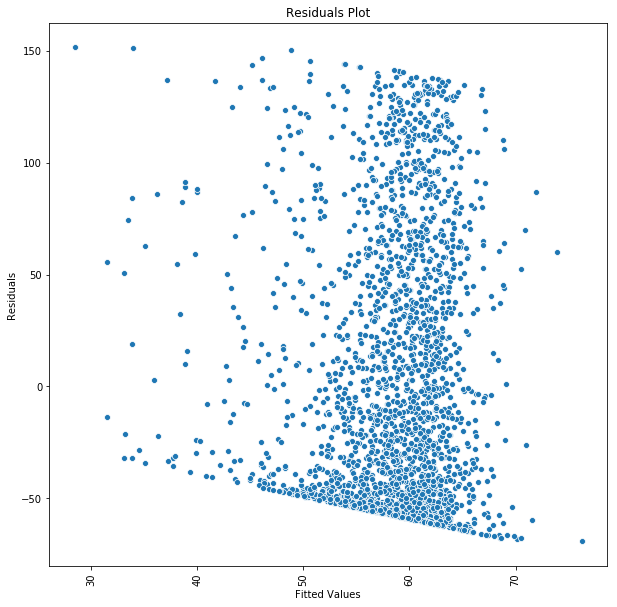

In [197]:
plt.figure(figsize = [10,10])
plt.title("Residuals Plot") #title for subplots
plt.xlabel("Fitted Values") #title for x axis
plt.ylabel("Residuals") #title for y axis
sns.scatterplot(y_hat, residuals)
plt.xticks(rotation='vertical')

## Multiple Linear Regression: Regressing Pitchfork Score on BNM and Review Polarity

The takeaway here is that Pitchfork's review polarity, BNM labeling, and album score have no statistically significant power in explaining or predicting an albums Billboard 200 ranking.

In [218]:
model_data = billfuzzypitch.query("hasreview == True")   
model_data = model_data.dropna()
model_data['intercept'] = 1

pitchfork_score = model_data['pitchfork score'].values

pitchfork_features = np.asarray(model_data.filter(['intercept','bnm', 'polarity'], axis = 1).values.tolist())


In [221]:
#model_pitchscoreonfeatures = sm.OLS(pitchfork_score, pitchfork_features).fit()
model_pitchscoreonfeatures = sm.OLS(model_data['pitchfork score'], model_data.filter(['intercept','bnm', 'polarity'], axis = 1)).fit()


model_pitchscoreonfeatures.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        pitchfork score   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     352.4
Date:                Fri, 14 Jun 2019   Prob (F-statistic):          2.46e-135
Time:                        18:12:41   Log-Likelihood:                -4284.3
No. Observations:                2470   AIC:                             8575.
Df Residuals:                    2467   BIC:                             8592.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.5540      0.039    167.108      0.000       6.477       6.631
bnm            1.9637      0.080     24.447      0.000       1.806       2.121
polarity       0.0061      0.001      6.408      0.000       0.004       0.008
==============================================================================
Omnibus:                      342.533   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              711.098
Skew:                          -0.836   Prob(JB):                    3.86e-155
Kurtosis:                       5.029   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interesting find! Based on these results, if an album is labeled "Best New Music", in general, Pitchfork's album score will increase by approximately 2 points. Also, since the Polarity of an album is not statistical significant, it shows that an album's polarity does not predict it's album score. This could either be based on a flaw in my method of ascertaining the polarity of an album. However, this could also be because the review itself is its own work of art, with the author of the review expressing her response to the album, rather than evaluating the music based off rigid criteria. It also lends to the idea that Pitchfork as a reviewing entity behaves more like an individual with specific preferences, rather than an agency meant to provide objective ratings.

Pitchfork's opinion of an album also has very little weight when it comes to predicting an albums success. Many succesful albums on the Billboard 200 were never reviewed by Pitchfork, and for the albums that Pitchfork did review, their score of an album bore no weight on its overall Billboard 200 success.

In [216]:
y_hat = model_pitchscoreonfeatures.fittedvalues
y = pitchfork_score

residuals = y - y_hat

5.72372026885522

(array([ 5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <a list of 10 Text xticklabel objects>)

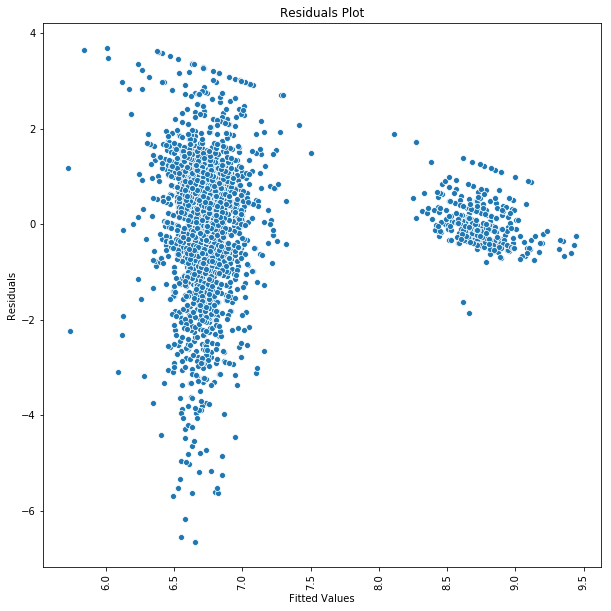

In [217]:
plt.figure(figsize = [10,10])
plt.title("Residuals Plot") #title for subplots
plt.xlabel("Fitted Values") #title for x axis
plt.ylabel("Residuals") #title for y axis
sns.scatterplot(y_hat, residuals)
plt.xticks(rotation='vertical')